# Lab 5: Bias-Variance tradeoff
As we discussed in a previous week, our linear regression model can be in one of the three states:

1. **Underfitting** - model is not powerful enough and fails to reproduce the dependencies in the data.
2. **Perfect fit** - sweet spot. Model learns the law that relates our features to target and performs almost equally well on a training data as well as on a data it has never seen before.
3. **Overfitting** - model is so powerful that it tries to extract information from the noise in features. As a result, model achieves high score on a training data but fails to generalize on an unseen data and we observe a significant drop in performance.

The extreme cases (1) and (3) are also reffered as **High-bias** and **High-variance** problems.

Let $y(x) = h(x) + \epsilon$ where $y(x)$ is our target, $h(x)$ is a regression function that describes the true relation between $x$ and $y$ and $ϵ\in N(0, σ^2)$ denote the function we learn from a dataset. Let $\hat{y}(x)$ denote the learned regression function.

Lets consider the loss function:

$$
  L = \sum_{i=0}^{|D|} (y(x_i) - \hat{y}(x_i))^2
$$

Now we can add and subtract $\mathbb{E}y$ and expand the sum:
$$
  L = \sum_{i=0}^{|D|} (y(x_i) - \mathbb{E}y + \mathbb{E}y - \hat{y}(x_i))^2 =\\
  L = \sum_{i=0}^{|D|} \biggr[(y(x_i) - \mathbb{E}y)^2 + 2 (y(x_i) - \mathbb{E}y) (\mathbb{E}y - \hat{y}(x_i)) + (\mathbb{E}y - \hat{y}(x_i))^2\biggr]
$$

Now if the take the expectation, the middle term vanishes because $\mathbb{E}y - y = 0$. Therefore we obtain:

$$
  \mathbb{E}L = \mathbb{E}\sum_{i=0}^{|D|} (y(x_i) - \mathbb{E}y)^2 + \mathbb{E}\sum_{i=0}^{|D|}(\mathbb{E}y - \hat{y}(x_i))^2
$$
The first term represents a variance in the data and the second term represents the squared bias of the model. Notice that derivation is made for some arbitrary sample $D$ from our feature space so obeserved biases and variances might differe. Further, the noise in the data also contributes to the loss, so overall we can summarize our derivation with the formula:

$$
  \textrm{expected loss} = \textrm{bias}^2 + \textrm{variance} + \textrm{noise}
$$

Lets try to model this phenomenon.

## Necessary imports and helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import random

plt.rcParams['figure.figsize'] = (12, 6)
random.seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def generate_data(N=25, std=0.3):
  x = np.linspace(0, 1, N, endpoint=True)
  y = np.sin(2 * np.pi * x)
  y_noisy = y + std * np.random.randn(N)
  return x.reshape(-1, 1), y_noisy, y

In [3]:
def get_model(reg_strength=0):
  """
    Returns a Linear regression with Gaussian kernel and L2 regularization
  """
  return KernelRidge(reg_strength, kernel='rbf')

In [4]:
def run_experiment(trials=100, reg_strength=0, N=25, std=0.03):
  predictions = []
  plt.suptitle(f'lambda = {reg_strength}')
  plt.subplot(1, 2, 1)
  for t in range(trials):
    x, y, _ = generate_data(N, std)
    model = get_model(reg_strength)
    model.fit(x, y)
    y_pred = model.predict(x)
    predictions.append(y_pred)
    if t < 20:
      plt.plot(x, y_pred)
  plt.xlabel('x')
  plt.ylabel('y')

  # Compute mean predictions
  plt.subplot(1, 2, 2)
  y_pred_mean = np.mean(predictions, axis=0)
  plt.plot(x, y_pred_mean, label='Mean prediction')
  plt.plot(x, np.sin(2 * np.pi * x), label='True data')
  plt.legend()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()


In [5]:
def run_bvt_experiment(lambda_min=-5, lambda_max=1, n_lambda=50):
  x_test, y_test, _ = generate_data(N=1000)
  lambdas = np.logspace(lambda_min, lambda_max, n_lambda)

  test_losses, test_biases, test_variances = [], [], []
  for l in lambdas:
    errors = []
    predictions = []
    for _ in range(100):
      x_train, y_train, _ = generate_data()
      model = get_model(reg_strength=l)
      model.fit(x_train, y_train)
      y_pred = model.predict(x_train)
      predictions.append(y_pred)
      errors.append(mean_squared_error(y_test, model.predict(x_test)))

    _, _, y_true = generate_data()
    average_predictions = np.mean(predictions, axis=0)
    bias_squared = np.mean((average_predictions - y_true)**2)
    var = np.mean(([(y_i - average_predictions)**2 for y_i in predictions]))

    test_biases.append(bias_squared)
    test_variances.append(var)
    test_losses.append(np.mean(errors))

  plt.title('Bias-variance tradeoff')
  plt.plot(lambdas, test_losses, label='Average test loss')
  plt.plot(lambdas, test_biases, label='Bias^2')
  plt.plot(lambdas, test_variances, label='Variance')
  plt.plot(lambdas, [b + v for b, v in zip(test_biases, test_variances)], label='Bias^2 + variance')
  plt.plot(lambdas, test_losses)
  plt.xscale('log')
  plt.legend()
  plt.show()

  print(np.linalg.norm(np.array(test_biases) + np.array(test_variances) - np.array(test_losses)))

## How model behaves?

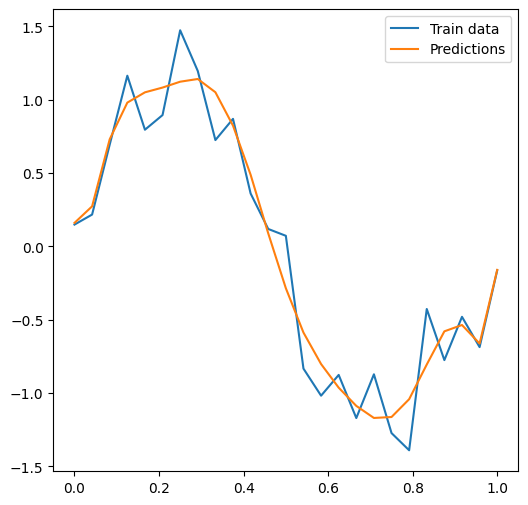

In [6]:
model = get_model()
x, y, _ = generate_data()

model.fit(x, y)

y_pred = model.predict(x)

fig=plt.figure(figsize=(6, 6))
plt.plot(x, y, label='Train data')
plt.plot(x, y_pred, label='Predictions')
plt.legend()

## Observing the effect of regularization

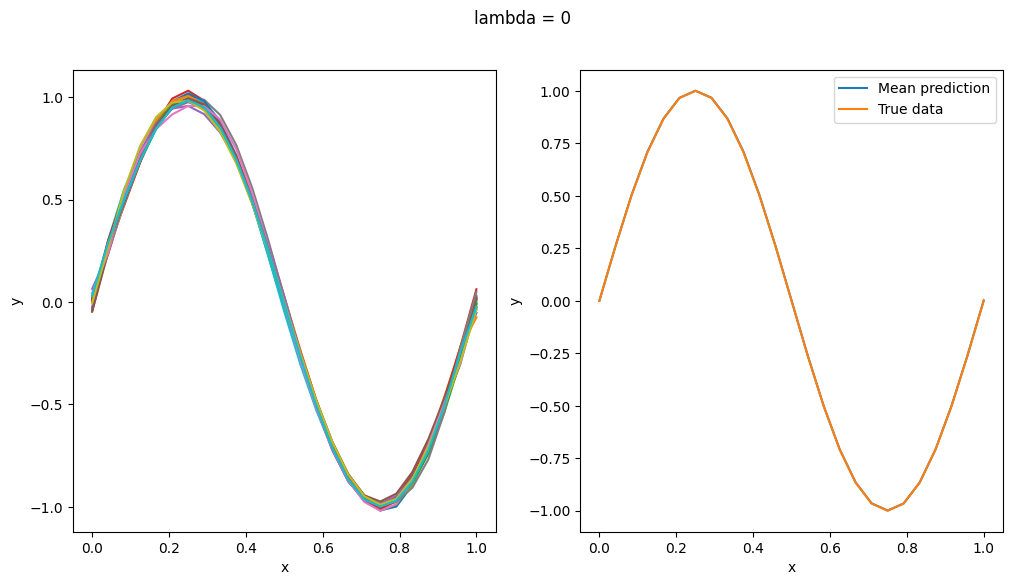

In [7]:
run_experiment()

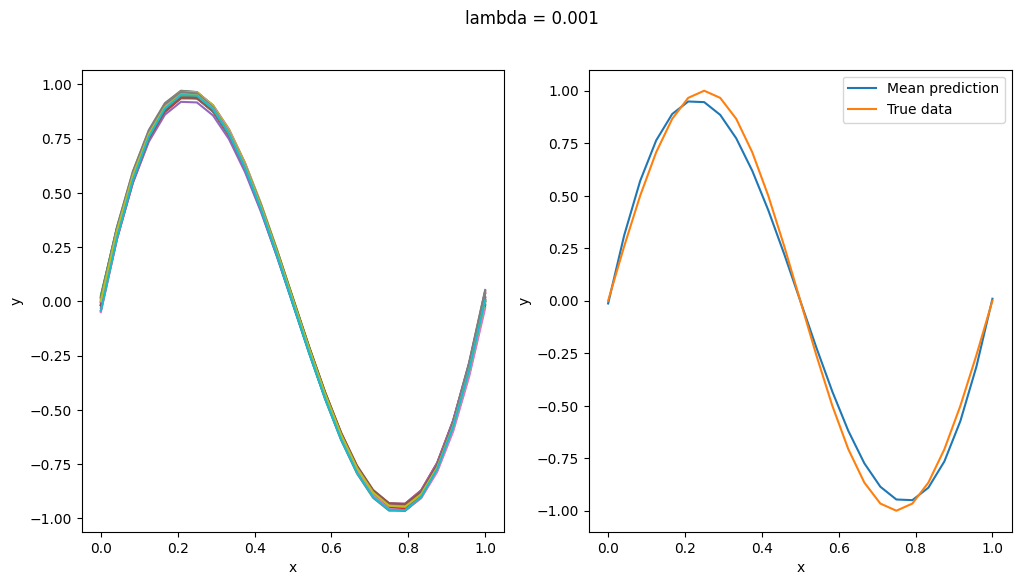

In [8]:
run_experiment(reg_strength=0.001)

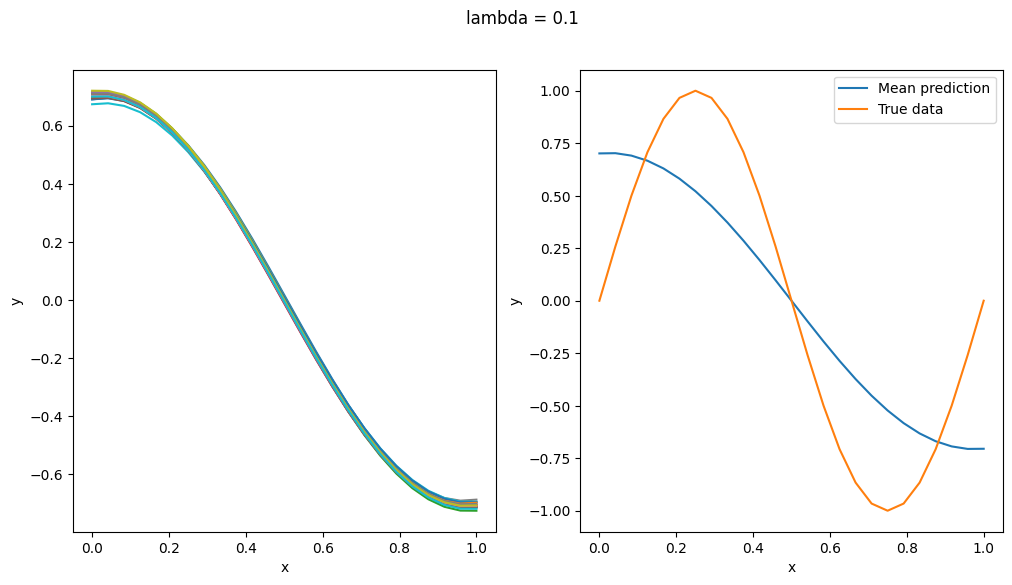

In [9]:
run_experiment(reg_strength=0.1)

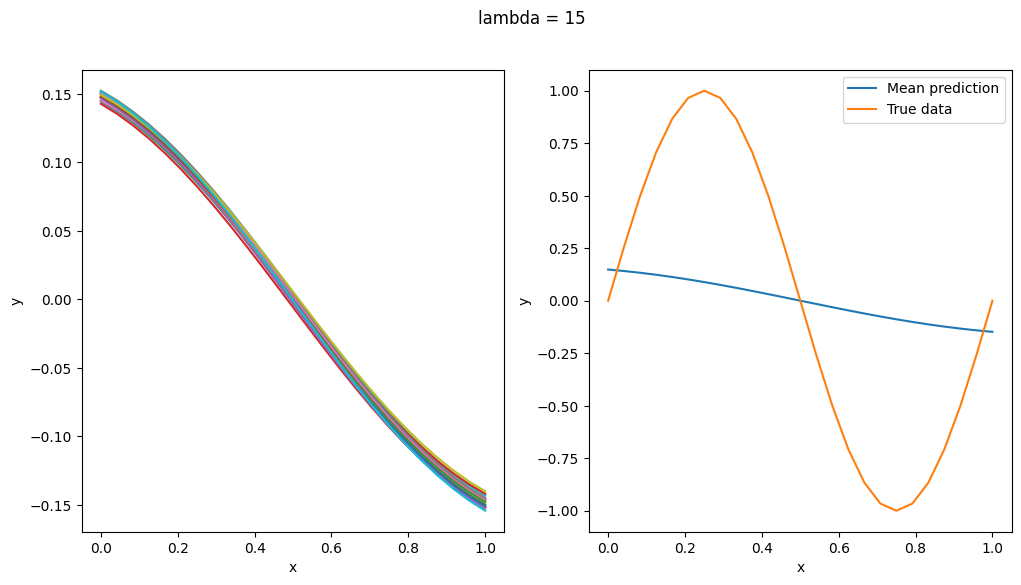

In [10]:
run_experiment(reg_strength=15)

As we could see, with a higher value of regularization parameter $\lambda$ the model becomes more stable in terms of variance but the bias grows significantly. Let's see this result in a slightly different visualization:

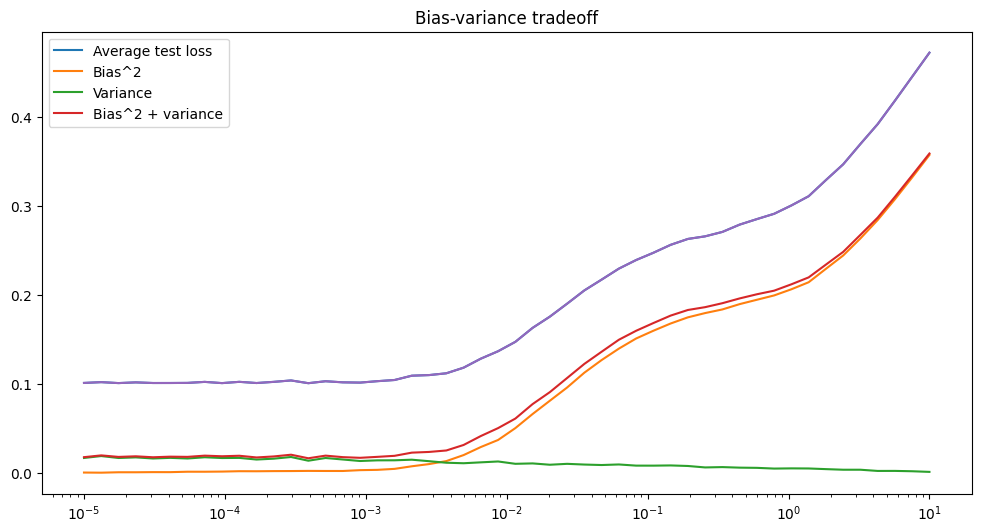

0.6140935895545432


In [11]:
run_bvt_experiment()

## References
For more details consider Chapter 3.2 from "Patterns Recognition and Machine Learning" by Christopher M. Bishop.